# Import modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcdefaults
from matplotlib.gridspec import GridSpec
from cycler import cycler

import numpy as np
from regions import CircleSkyRegion, PointSkyRegion
from pathlib import Path
import os
import operator
import pickle
import mplhep as hep
from gammapy.stats import WStatCountsStatistic

In [2]:
from gammapy.data import DataStore
from gammapy.datasets import (
    Datasets,
    FluxPointsDataset,
    SpectrumDataset,
    SpectrumDatasetOnOff,
)
from gammapy.estimators import FluxPointsEstimator, LightCurveEstimator, FluxPoints
from gammapy.makers import (
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    WobbleRegionsFinder,
)
from gammapy.maps import MapAxis, RegionGeom, WcsGeom
from gammapy.maps import TimeMapAxis
TimeMapAxis.time_format = "mjd"

from gammapy.modeling import Fit
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    LogParabolaSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    CompoundSpectralModel,
    BrokenPowerLawSpectralModel,
    SmoothBrokenPowerLawSpectralModel,
    EBLAbsorptionNormSpectralModel,
    create_crab_spectral_model,
    SkyModel,
)
from gammapy.visualization import plot_spectrum_datasets_off_regions

from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.table import Table, QTable
from astropy.time import Time
import astropy.units as u

from scipy.stats import chi2, norm

# Load the data

In [3]:
dir_path = "/home/joshua.baxter/Work/LST-1_analysis/Paper_AGN/Mrk421/data/DL3/v0.9.13/g_80/OfficialRF_dec_3476/"

In [4]:
total_datastore = DataStore.from_dir(dir_path)

#ogip_path = Path(dir_path + 'OGIP/')
plot_path = Path(dir_path + "plots/")
plot_dataset_path = Path(dir_path + 'plots/datasets/')

# Create the Paths if they do not exist already
#ogip_path.mkdir(exist_ok=True)
plot_path.mkdir(exist_ok=True)
plot_dataset_path.mkdir(exist_ok=True)

In [ ]:
total_datastore

## Wrong coding

In [6]:
total_obs_list = total_datastore.obs_table["OBS_ID"].data
observations_total = total_datastore.get_observations(
    total_obs_list,
    skip_missing=False
)

Skipping run with missing HDUs; Required HDUs ['psf', 'bkg'] not found in observation 3218
Skipping run with missing HDUs; Required HDUs ['psf', 'bkg'] not found in observation 3219
Skipping run with missing HDUs; Required HDUs ['psf', 'bkg'] not found in observation 3220
Skipping run with missing HDUs; Required HDUs ['psf', 'bkg'] not found in observation 3221
Skipping run with missing HDUs; Required HDUs ['psf', 'bkg'] not found in observation 3222
Skipping run with missing HDUs; Required HDUs ['psf', 'bkg'] not found in observation 3223
Skipping run with missing HDUs; Required HDUs ['psf', 'bkg'] not found in observation 3224
Skipping run with missing HDUs; Required HDUs ['psf', 'bkg'] not found in observation 3225
Skipping run with missing HDUs; Required HDUs ['psf', 'bkg'] not found in observation 3226
Skipping run with missing HDUs; Required HDUs ['psf', 'bkg'] not found in observation 3227
Skipping run with missing HDUs; Required HDUs ['psf', 'bkg'] not found in observation 3238

Skipping run with missing HDUs; Required HDUs ['psf', 'bkg'] not found in observation 6940
Skipping run with missing HDUs; Required HDUs ['psf', 'bkg'] not found in observation 6941
Skipping run with missing HDUs; Required HDUs ['psf', 'bkg'] not found in observation 6947
Skipping run with missing HDUs; Required HDUs ['psf', 'bkg'] not found in observation 6948
Skipping run with missing HDUs; Required HDUs ['psf', 'bkg'] not found in observation 6949
Skipping run with missing HDUs; Required HDUs ['psf', 'bkg'] not found in observation 6950
Skipping run with missing HDUs; Required HDUs ['psf', 'bkg'] not found in observation 6951
Skipping run with missing HDUs; Required HDUs ['psf', 'bkg'] not found in observation 6952
Skipping run with missing HDUs; Required HDUs ['psf', 'bkg'] not found in observation 6994
Skipping run with missing HDUs; Required HDUs ['psf', 'bkg'] not found in observation 6997
Skipping run with missing HDUs; Required HDUs ['psf', 'bkg'] not found in observation 6998

## Correct one

###### https://docs.gammapy.org/1.0/api/gammapy.data.DataStore.html?highlight=datastore#gammapy.data.DataStore.get_observations
Runs will be added to the list of observations only if the required HDUs are present. Otherwise, the given run will be skipped The list can include the following options:

    "events" : Events
    "gti" : Good time intervals
    "aeff" : Effective area
    "bkg" : Background
    "edisp": Energy dispersion
    "psf" : Point Spread Function
    "rad_max" : Maximal radius

    Alternatively single string can be used as shortcut:
    "full-enclosure" : includes ["events", "gti", "aeff", "edisp", "psf", "bkg"]
    "point-like" : includes ["events", "gti", "aeff", "edisp"]
    "all-optional" : no HDUs are required, only warnings will be emitted for missing HDUs among all possibilitie

In [11]:
## What happend??
## You just needed required_irf!

observations_total = total_datastore.get_observations(
    total_obs_list, 
    required_irf=["aeff", "edisp", "rad_max"], # By default, "all" = ["aeff", "edisp", "bkg", "psf"]. 
                        # If not all IRFs are present, the entry will be skipped 
    skip_missing=False # Skip missing observations, within the list provided earlier
)

# Let's do some selection of observations

In [13]:
print("All unique source objects:", np.unique(total_datastore.obs_table["OBJECT"].data))
print("Minimum LIVETIME in seconds:", np.amin(total_datastore.obs_table["LIVETIME"].data))
print("Maximum Zenith in deg:", np.amax(total_datastore.obs_table["ZEN_PNT"].data))

All unique source objects: [b'Mrk421']
Minimum LIVETIME in seconds: 38.94114044998944
Maximum Zenith in deg: 55.9269937193308


In [15]:
obj_name = np.unique(total_datastore.obs_table["OBJECT"])[0]
print("The source is", obj_name)

The source is Mrk421


In [16]:
min_time = 300 # in s
max_zen = 50 # in deg


d_wob = [total_datastore.obs_table["OBS_MODE"] == 'POINTING']
d_time = [total_datastore.obs_table["LIVETIME"] > min_time]
d_zen = [total_datastore.obs_table["ZEN_PNT"] < max_zen]
d_obj = [total_datastore.obs_table["OBJECT"] == obj_name]

wob_obs_table = total_datastore.obs_table[
    d_wob[0]*d_zen[0]*d_obj[0]*d_time[0]
]
wob_obs_list = wob_obs_table["OBS_ID"]

observations_wob = total_datastore.get_observations(
    wob_obs_list.data, 
    required_irf=["aeff", "edisp", "rad_max"] #, "bkg", "point-like", "all-optional"
)

In [26]:
observations_wob[1].obs_id

3219

# Checking the DL3 cut distribution

Text(0, 0.5, 'theta [deg]')

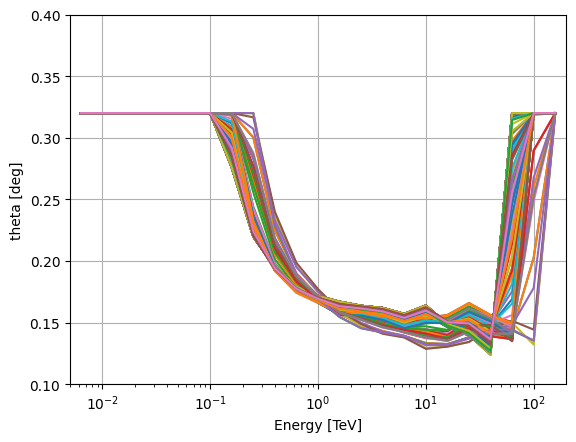

In [30]:
ax = observations_wob[0].rad_max.plot_rad_max_vs_energy()
plt.grid()

for o in observations_wob:
    o.rad_max.plot_rad_max_vs_energy()
ax.legend().remove()
ax.set_ylim(0.1, 0.4)
ax.yaxis.set_major_formatter("{x:.2f}")
ax.set_ylabel("theta [deg]")

# Define target position

In [31]:
target_position = SkyCoord.from_name(obj_name, frame='icrs')

# Enegy ranges

In [32]:
e_reco_min = 0.01
e_fit_min = 0.04
e_reco_max = 100
e_fit_max = 10

e_true_min = 0.01
e_true_max = 100

# Using bins per decade
e_fit_bin_p_dec = e_reco_bin_p_dec = 5
e_true_bin_p_dec = 5

energy_fit_edges = MapAxis.from_energy_bounds(
    e_fit_min, e_fit_max, 
    nbin=e_fit_bin_p_dec, per_decade=True, 
    unit="TeV"
).edges

energy_axis = MapAxis.from_energy_bounds(
    e_reco_min, e_reco_max, 
    nbin=e_reco_bin_p_dec, per_decade=True, 
    unit="TeV", name="energy"
)
energy_axis_true = MapAxis.from_energy_bounds(
    e_true_min, e_true_max, 
    nbin=e_true_bin_p_dec, per_decade=True, 
    unit="TeV", name="energy_true"
)

# Select minimum and maximum energy edges for LC estimation, from the energy_axis to be used un the Dataset
e_lc_min = 100*u.GeV
e_lc_max = energy_axis.edges[-1]

print(energy_axis.edges)
print(energy_fit_edges)
print(e_lc_min, e_lc_max)

[1.00000000e-02 1.58489319e-02 2.51188643e-02 3.98107171e-02
 6.30957344e-02 1.00000000e-01 1.58489319e-01 2.51188643e-01
 3.98107171e-01 6.30957344e-01 1.00000000e+00 1.58489319e+00
 2.51188643e+00 3.98107171e+00 6.30957344e+00 1.00000000e+01
 1.58489319e+01 2.51188643e+01 3.98107171e+01 6.30957344e+01
 1.00000000e+02] TeV
[ 0.04        0.06337067  0.10039606  0.15905415  0.25198421  0.39921023
  0.63245553  1.00197833  1.58740105  2.51486686  3.98422019  6.31206796
 10.        ] TeV
100.0 GeV 100.00000000000004 TeV


# Creating time intervals for plotting Light Curves

In [33]:
%%time
# Get the GTI parameters of each observations to create time intervals for plotting LC
t_start = []
t_stop = []
tot_time = []

t_start_short = []
t_stop_short = []

for obs in observations_wob:
    gti = obs.gti
    t_start.append(gti.time_start[0])
    t_stop.append(gti.time_stop[0])
    tot_time.append(gti.time_sum.value)
        
t_start = np.sort(np.array(t_start))
t_stop = np.sort(np.array(t_stop))
tot_time = np.array(tot_time)

t_start = Time(t_start)
t_stop = Time(t_stop)

t_day = np.unique(np.rint(t_start.mjd))

# To make the range night-wise, keep the MJD range in half integral values
t_range = [Time([t-0.5, t+0.5], format="mjd", scale="utc") for t in t_day]

CPU times: user 1.46 s, sys: 145 ms, total: 1.6 s
Wall time: 2.14 s


# Basemap geometries

In [34]:
on_region = PointSkyRegion(target_position)  ## Need to use PointSkyRegion for energy-dependant theta cut!!!

# This will create the base geometry in which to bin the events based on their reconstructed positions
on_geom = RegionGeom.create(
    on_region, 
    axes=[energy_axis]
)

# Data Reduction

In [ ]:
# Exclusion region/source for Crab - RGB J0521+212. 
# Can include specific close gamma-ray objects with respect to the given source, after looking at catalogs
# like http://gamma-sky.net/

# If need be, one can also modify the size of the region, in the previous cell, to exclude some regions
exclusion_region = CircleSkyRegion(
    center=SkyCoord.from_name("RGB J0521+212", frame="galactic"),
    radius=0.5 * u.deg,
)

skydir = target_position.galactic
excluded_geom = WcsGeom.create(
    npix=(100, 100), binsz=0.05, 
    skydir=skydir, proj="TAN", frame="icrs"
)

exclusion_mask = ~excluded_geom.region_mask([exclusion_region])

In [35]:
# Create some Dataset and Data Reduction Makers
# geom is the target geometry in reco energy for counts and background maps
# energy_axis_true is the true energy axis for the IRF maps
dataset_empty = SpectrumDataset.create(
    geom=on_geom, 
    energy_axis_true=energy_axis_true
)
# When not including a PSF IRF, put the containment_correction as False
dataset_maker = SpectrumDatasetMaker(
    containment_correction=False, 
    selection=["counts", "exposure", "edisp"]
)

In [38]:
# The following makers can be tuned and played to check the final Dataset to be used.
# Select the necessary number and size of the OFF regions, to be chosen by this method

wobble_off_regions = 1

region_finder = WobbleRegionsFinder(n_off_regions=wobble_off_regions)
bkg_maker = ReflectedRegionsBackgroundMaker(region_finder,exclusion_mask=exclusion_mask)

In [39]:
%%time
# The final object will be stored as a Datasets object
datasets = Datasets()
i=0
for obs_id, observation in zip(wob_obs_list.data, observations_wob):
    dataset = dataset_maker.run(
        dataset_empty.copy(name=str(obs_id)), 
        observation
    )
    print(i, 'obs_id:', obs_id)
    
    i+=1
    dataset_on_off = bkg_maker.run(
        dataset=dataset, 
        observation=observation
    )
    
    datasets.append(dataset_on_off)

0 obs_id: 3218
1 obs_id: 3219
2 obs_id: 3220
3 obs_id: 3221
4 obs_id: 3222
5 obs_id: 3223
6 obs_id: 3224
7 obs_id: 3225
8 obs_id: 3226
9 obs_id: 3227
10 obs_id: 3238
11 obs_id: 3239
12 obs_id: 3247
13 obs_id: 3248
14 obs_id: 3249
15 obs_id: 3250
16 obs_id: 3661
17 obs_id: 3662
18 obs_id: 3663
19 obs_id: 3664
20 obs_id: 3665
21 obs_id: 3666
22 obs_id: 3667
23 obs_id: 3668
24 obs_id: 3687
25 obs_id: 3688
26 obs_id: 3715
27 obs_id: 3716
28 obs_id: 3717
29 obs_id: 3718
30 obs_id: 3720
31 obs_id: 3721
32 obs_id: 3732
33 obs_id: 3733
34 obs_id: 3734
35 obs_id: 3735
36 obs_id: 3736
37 obs_id: 3737
38 obs_id: 4016
39 obs_id: 4017
40 obs_id: 4018
41 obs_id: 4019
42 obs_id: 4097
43 obs_id: 4098
44 obs_id: 4099
45 obs_id: 4100
46 obs_id: 4131
47 obs_id: 4132
48 obs_id: 4133
49 obs_id: 4134
50 obs_id: 4135
51 obs_id: 4136
52 obs_id: 4137
53 obs_id: 4138
54 obs_id: 4153
55 obs_id: 4154
56 obs_id: 4155
57 obs_id: 4156
58 obs_id: 4184
59 obs_id: 4185
60 obs_id: 4186
61 obs_id: 4187
62 obs_id: 4188
63

In [40]:
plt.figure()
#ax = counts.plot(cmap="viridis")
ax = exclusion_mask.plot()
on_geom.plot_region(ax =ax,kwargs_point={"color": "k", "marker": "*"})
plot_spectrum_datasets_off_regions(ax=ax,datasets=datasets)

NameError: name 'exclusion_mask' is not defined

<Figure size 640x480 with 0 Axes>

# Plots

In [42]:
info_table = datasets.info_table(cumulative=True)
info_table

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,17590,308.0,1.64935868560873,17282.0,17436.0,17436.0,nan,584514.1875,375912544.0,777.8408343916693,806.8239560127258,22.613880915311828,22.21791301753377,0.3959678977780582,20,20,wstat,28.913867105435195,17282,20.0,20.0,1.0
stacked,41076,583.0,2.041304695441115,40493.0,40784.5,40784.5,nan,252420.640625,844302336.0,1890.7349006846111,1957.3768556118011,21.72488590818676,21.41654019573976,0.30834571244699777,20,20,wstat,69.48059873901661,40493,20.0,20.0,1.0
stacked,62984,1596.0,4.525614299060108,61388.0,62186.0,62186.0,nan,632065.1875,1163521280.0,2785.947952689806,2882.00909614563,22.607744677781778,22.034869653875077,0.572875023906702,20,20,wstat,173.01379156239557,61388,20.0,20.0,1.0
stacked,94771,560.0,1.2881846635912508,94211.0,94491.0,94491.0,nan,1348878.25,1490099712.0,3854.5384509408977,3991.8372025489807,24.586860711394973,24.441577428551263,0.14528328284370942,20,20,wstat,192.20534202482372,94211,20.0,20.0,1.0
stacked,125961,2070.0,4.141249672647787,123891.0,124926.0,124926.0,nan,2039036.25,1715499904.0,4666.723734172969,4837.335454463959,26.991312787090163,26.547746782777107,0.4435660043130543,20,20,wstat,262.94807704627215,123891,20.0,20.0,1.0
stacked,165544,1972.0,3.437428804765704,163572.0,164558.0,164558.0,nan,3212465.0,1992585088.0,5755.383341806682,5968.962909936905,28.76333167896924,28.420695944234502,0.34263573473473724,20,20,wstat,339.5247494845021,163572,20.0,20.0,1.0
stacked,205064,3214.0,5.038448388544779,201850.0,203457.0,203457.0,nan,4608227.0,2239162112.0,6799.816436701149,7055.43555355072,30.157284672155708,29.684624854068144,0.4726598180875651,20,20,wstat,424.8255702096062,201850,20.0,20.0,1.0
stacked,242730,3977.0,5.73149055830983,238753.0,240741.5,240741.5,nan,6416819.0,2472097024.0,7872.167977716999,8167.79501247406,30.833945704293,30.32874815118472,0.505197553108282,20,20,wstat,505.77151211694786,238753,20.0,20.0,1.0


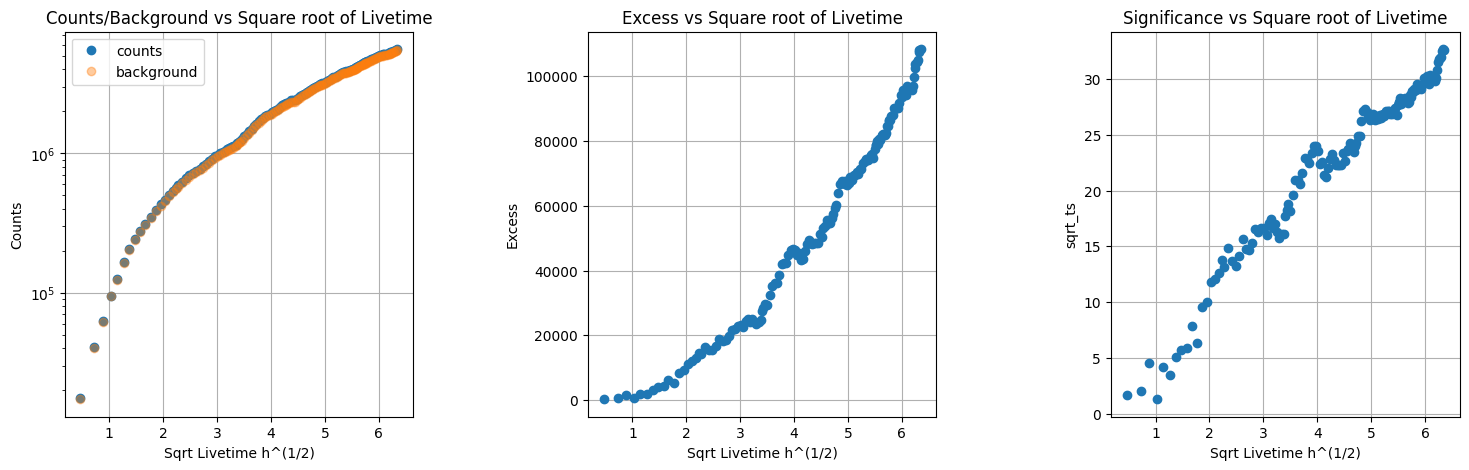

In [43]:
# Plot temporal evolution of excess events and significance value
plt.figure(figsize=(18,5))
plt.subplot(131)
plt.plot(
    np.sqrt(info_table["livetime"].to("h")), info_table["counts"], 
    marker="o", ls="none", label="counts"
)
plt.plot(
    np.sqrt(info_table["livetime"].to("h")), info_table["background"], 
    marker="o", ls="none", alpha=0.4, label="background"
)
#plt.plot(info_table["livetime"].to("h")[-1:1], info_table["excess"][-1:1], 'r')
plt.xlabel("Sqrt Livetime h^(1/2)")
plt.ylabel("Counts")
plt.grid()
plt.legend()
plt.yscale("log")
plt.title('Counts/Background vs Square root of Livetime')

plt.subplot(132)
plt.plot(
    np.sqrt(info_table["livetime"].to("h")), info_table["excess"], marker="o", ls="none"
)
#plt.plot(info_table["livetime"].to("h")[-1:1], info_table["excess"][-1:1], 'r')
plt.xlabel("Sqrt Livetime h^(1/2)")
plt.ylabel("Excess")
plt.grid()
plt.title('Excess vs Square root of Livetime')

plt.subplot(133)
plt.plot(
    np.sqrt(info_table["livetime"].to("h")),
    info_table["sqrt_ts"],
    marker="o",
    ls="none",
)
plt.grid()
plt.xlabel("Sqrt Livetime h^(1/2)")
plt.ylabel("sqrt_ts")
plt.title('Significance vs Square root of Livetime')
plt.subplots_adjust(wspace=0.5)

# Further Analysis

In [44]:
stacked_dataset = datasets.stack_reduce()

In [ ]:
print(stacked_dataset)

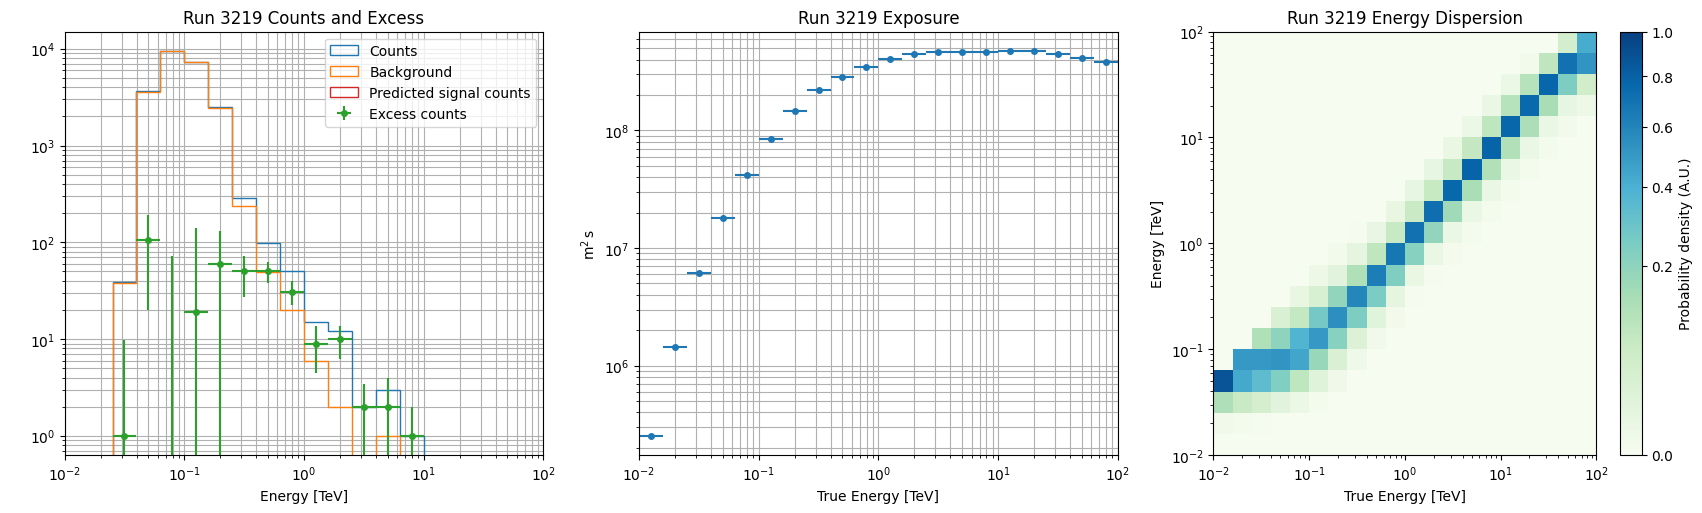

In [48]:
data = datasets[1]
plt.figure(figsize=(21, 5.5))
plt.subplot(131)
data.plot_counts()
data.plot_excess()
plt.grid(which="both")
plt.title(f'Run {data.name} Counts and Excess')

plt.subplot(132)
data.exposure.plot()
plt.grid(which='both')
plt.title(f'Run {data.name} Exposure')

plt.subplot(133)
if data.edisp is not None:
    kernel = data.edisp.get_edisp_kernel()
    kernel.plot_matrix(add_cbar=True)
    plt.title(f'Run {data.name} Energy Dispersion')

# Get the pivot energy

In [49]:
# Find pivot (decorrelation) energy for a Power Law model to get the reference energy for Log Parabola model
def get_pivot_energy(datasets, e_ref, e_edges, obj_name):
    """
    Using Power Law spectral model with the given reference energy and 
    get the decorrelation energy of the fit, within the fit energy range, e_edges.
    This method is further explained in doi:10.1088/0004-637X/707/2/1310
    """
    spectral_model = PowerLawSpectralModel(
        index=2, amplitude=2e-10 * u.Unit("cm-2 s-1 TeV-1"), reference=e_ref
    )
    model = SkyModel(spectral_model=spectral_model, name=obj_name)
    model_check = model.copy()

    # Stacked dataset method
    stacked_dataset = datasets.stack_reduce()
    stacked_dataset.models = model_check

    fit_stacked = Fit()
    result_stacked = fit_stacked.run(datasets=stacked_dataset)

    return model_check.spectral_model.pivot_energy


In [50]:
# Using a reference energy close to the expected decorrelation energy
ref = get_pivot_energy(datasets, 0.6* u.TeV, energy_axis.edges, obj_name)
print(ref.to_value(u.GeV))

362.9379049295308


In [51]:
spectral_model_lp = LogParabolaSpectralModel(
        amplitude = 5e-11 * u.Unit('cm-2 s-1 TeV-1'),
        reference = ref,
        alpha = 2 * u.Unit(''),
        beta = 0.1 * u.Unit('')
)

In [52]:
redshift = 0.034
dominguez = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=redshift)
franceschini = EBLAbsorptionNormSpectralModel.read_builtin(
    "franceschini", redshift=redshift
)
finke = EBLAbsorptionNormSpectralModel.read_builtin("finke", redshift=redshift)

In [53]:
model_lp_ebl_d = SkyModel(
    spectral_model=spectral_model_lp*dominguez, 
    name=obj_name
)

# Spectral fitting

In [54]:
stacked_dataset.models = model_lp_ebl_d

In [55]:
# Fitting the model to the dataset
fit = Fit()
result = fit.run(datasets=stacked_dataset)
model_best = model_lp_ebl_d

/home/joshua.baxter/Work/anaconda3/envs/gammapy_v1.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [56]:
model_best.to_dict()

{'name': 'Mrk421',
 'type': 'SkyModel',
 'spectral': {'type': 'CompoundSpectralModel',
  'model1': {'type': 'LogParabolaSpectralModel',
   'parameters': [{'name': 'amplitude',
     'value': 2.2805538689311613e-10,
     'unit': 'cm-2 s-1 TeV-1',
     'error': 3.1813929998178455e-12},
    {'name': 'reference', 'value': 0.3629379049295308, 'unit': 'TeV'},
    {'name': 'alpha',
     'value': 2.4716958951385397,
     'error': 0.014500773893080085},
    {'name': 'beta',
     'value': 0.1254352803880233,
     'error': 0.01053679318912057}]},
  'model2': {'type': 'EBLAbsorptionNormSpectralModel',
   'parameters': [{'name': 'alpha_norm', 'value': 1.0},
    {'name': 'redshift', 'value': 0.034}],
   'filename': '/fefs/aswg/workspace/joshua.baxter/gammapy-tutorials/datasets/ebl/ebl_dominguez11.fits.gz'},
  'operator': 'mul'}}

# Flux estimation

In [58]:
print(e_lc_min, e_lc_max)

100.0 GeV 100.00000000000004 TeV


In [59]:
# Create the LC Estimator for each run and for each night
lc_maker_1d = LightCurveEstimator(
    energy_edges=[e_lc_min, e_lc_max], 
    reoptimize=False, # Re-optimizing other free model parameters (not belonging to the source)
    source=obj_name, 
    selection_optional="all" # Estimates asymmetric errors, upper limits and fit statistic profiles
)
lc_maker_night_wise = LightCurveEstimator(
    energy_edges=[e_lc_min, e_lc_max], 
    time_intervals=t_range,
    reoptimize=False, 
    source=obj_name,
    selection_optional="all"
)

In [60]:
%%time
# Assigning the best fit model for each dataset
for data in datasets:
    data.models = model_best

lc_1d = lc_maker_1d.run(datasets)
lc_night = lc_maker_night_wise.run(datasets)

CPU times: user 2min 35s, sys: 504 ms, total: 2min 35s
Wall time: 2min 35s


In [63]:
# Compute the Flux Points after Fitting the model
# We do not do too many optimizations here. 
# If one wants, can try and check the various attributes of the Estimator
fpe = FluxPointsEstimator(
    energy_edges=energy_fit_edges, 
    reoptimize = False, # Re-optimizing other free model parameters (not belonging to the source)
    source=obj_name,
    selection_optional="all" # Estimates asymmetric errors, upper limits and fit statistic profiles
)
flux_points = fpe.run(datasets=stacked_dataset)

flux_points_dataset = FluxPointsDataset(
    data=flux_points, models=model_best
)

In [64]:
# EBL deabsorbed
models2= SkyModel(
    spectral_model=model_best.spectral_model.model1.copy(), 
    name=obj_name
)

In [65]:
# Check the Flux table
# sed_type options are {“likelihood”, “dnde”, “e2dnde”, “flux”, “eflux”} with "likelihood" being default
# format options are {“gadf-sed”, “lightcurve”, “binned-time-series”, “profile”} with "gadf-sed" being default
flux_points.to_table(formatted=True, sed_type="e2dnde")

e_ref,e_min,e_max,e2dnde,e2dnde_err,e2dnde_errp,e2dnde_errn,e2dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,bool,float64[1],bool,float64[11],float64[11]
0.050,0.040,0.063,5.848e-11,5.828e-12,5.773e-12,5.773e-12,7.002e-11,102.584,10.128,1946945.3322673794,19935.66,0.000,False,1946945.0,True,0.200 .. 5.000,72.422 .. 919.680
0.079,0.063,0.100,4.748e-11,3.860e-12,3.929e-12,3.929e-12,5.534e-11,146.070,12.086,1411011.005638463,20230.012,0.000,False,1411011.0,True,0.200 .. 5.000,95.052 .. 2144.921
0.126,0.100,0.158,3.223e-11,2.403e-12,2.433e-12,2.433e-12,3.709e-11,175.485,13.247,626347.8497744342,14738.703,0.000,False,626348.0,True,0.200 .. 5.000,94.983 .. 5502.692
0.200,0.158,0.251,3.680e-11,1.342e-12,1.342e-12,1.342e-12,3.948e-11,752.096,27.424,171759.9991551604,15698.998,0.000,False,171760.0,True,0.200 .. 5.000,479.841 .. 11938.196
0.316,0.251,0.398,2.939e-11,7.016e-13,7.017e-13,7.014e-13,3.079e-11,1762.942,41.987,36375.9758179964,10454.959,0.000,False,36376.0,True,0.200 .. 5.000,1123.170 .. 23524.430
0.501,0.398,0.631,2.261e-11,4.731e-13,4.735e-13,4.726e-13,2.356e-11,2337.134,48.344,11936.23922143596,6329.882,0.000,False,11937.0,True,0.200 .. 5.000,1533.999 .. 20134.273
0.794,0.631,1.000,1.424e-11,3.992e-13,3.999e-13,3.986e-13,1.505e-11,1314.825,36.261,4966.780682724987,2975.6929,0.000,False,4967.0,True,0.200 .. 5.000,839.509 .. 11471.110
1.259,1.000,1.585,9.603e-12,3.610e-13,3.622e-13,3.599e-13,1.033e-11,741.025,27.222,2118.691030161021,1413.5883,0.000,False,2119.0,True,0.200 .. 5.000,488.795 .. 5198.168


In [66]:
model_best.to_dict()

{'name': 'Mrk421',
 'type': 'SkyModel',
 'spectral': {'type': 'CompoundSpectralModel',
  'model1': {'type': 'LogParabolaSpectralModel',
   'parameters': [{'name': 'amplitude',
     'value': 2.2805538689311613e-10,
     'unit': 'cm-2 s-1 TeV-1',
     'error': 3.1813929998178455e-12},
    {'name': 'reference', 'value': 0.3629379049295308, 'unit': 'TeV'},
    {'name': 'alpha',
     'value': 2.4716958951385397,
     'error': 0.014500773893080085},
    {'name': 'beta',
     'value': 0.1254352803880233,
     'error': 0.01053679318912057}]},
  'model2': {'type': 'EBLAbsorptionNormSpectralModel',
   'parameters': [{'name': 'alpha_norm', 'value': 1.0},
    {'name': 'redshift', 'value': 0.034}],
   'filename': '/fefs/aswg/workspace/joshua.baxter/gammapy-tutorials/datasets/ebl/ebl_dominguez11.fits.gz'},
  'operator': 'mul'}}

In [67]:
# Add the Fit results to the model object to save it to file
model_final = model_best.to_dict()
model_final["FitResult"] = {
    "Optimize": result.optimize_result,
    "Covariance": result.covariance_result
}
model_final

{'name': 'Mrk421',
 'type': 'SkyModel',
 'spectral': {'type': 'CompoundSpectralModel',
  'model1': {'type': 'LogParabolaSpectralModel',
   'parameters': [{'name': 'amplitude',
     'value': 2.2805538689311613e-10,
     'unit': 'cm-2 s-1 TeV-1',
     'error': 3.1813929998178455e-12},
    {'name': 'reference', 'value': 0.3629379049295308, 'unit': 'TeV'},
    {'name': 'alpha',
     'value': 2.4716958951385397,
     'error': 0.014500773893080085},
    {'name': 'beta',
     'value': 0.1254352803880233,
     'error': 0.01053679318912057}]},
  'model2': {'type': 'EBLAbsorptionNormSpectralModel',
   'parameters': [{'name': 'alpha_norm', 'value': 1.0},
    {'name': 'redshift', 'value': 0.034}],
   'filename': '/fefs/aswg/workspace/joshua.baxter/gammapy-tutorials/datasets/ebl/ebl_dominguez11.fits.gz'},
  'operator': 'mul'},
 'FitResult': {'Optimize': OptimizeResult
  
  	backend    : minuit
  	method     : migrad
  	success    : True
  	message    : Optimization terminated successfully.
  	nfev 

In [68]:
model_best.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str10,float64,str14,float64,float64,float64,bool,bool,str1
spectral,amplitude,2.2806e-10,cm-2 s-1 TeV-1,3.181e-12,nan,nan,False,True,
spectral,reference,3.6294e-01,TeV,0.000e+00,nan,nan,True,False,
spectral,alpha,2.4717e+00,,1.450e-02,nan,nan,False,False,
spectral,beta,1.2544e-01,,1.054e-02,nan,nan,False,False,
spectral,alpha_norm,1.0000e+00,,0.000e+00,nan,nan,True,False,
spectral,redshift,3.4000e-02,,0.000e+00,nan,nan,True,False,


# Check the fit 

In [69]:
if len(stacked_dataset.models.parameters)> 3:
    nrow = int(np.sqrt(len(stacked_dataset.models.parameters)))
    ncol = int(np.ceil(len(stacked_dataset.models.parameters)/nrow))
else:
    ncol = len(stacked_dataset.models.parameters)
    nrow = 1
print(ncol, nrow)

3 2


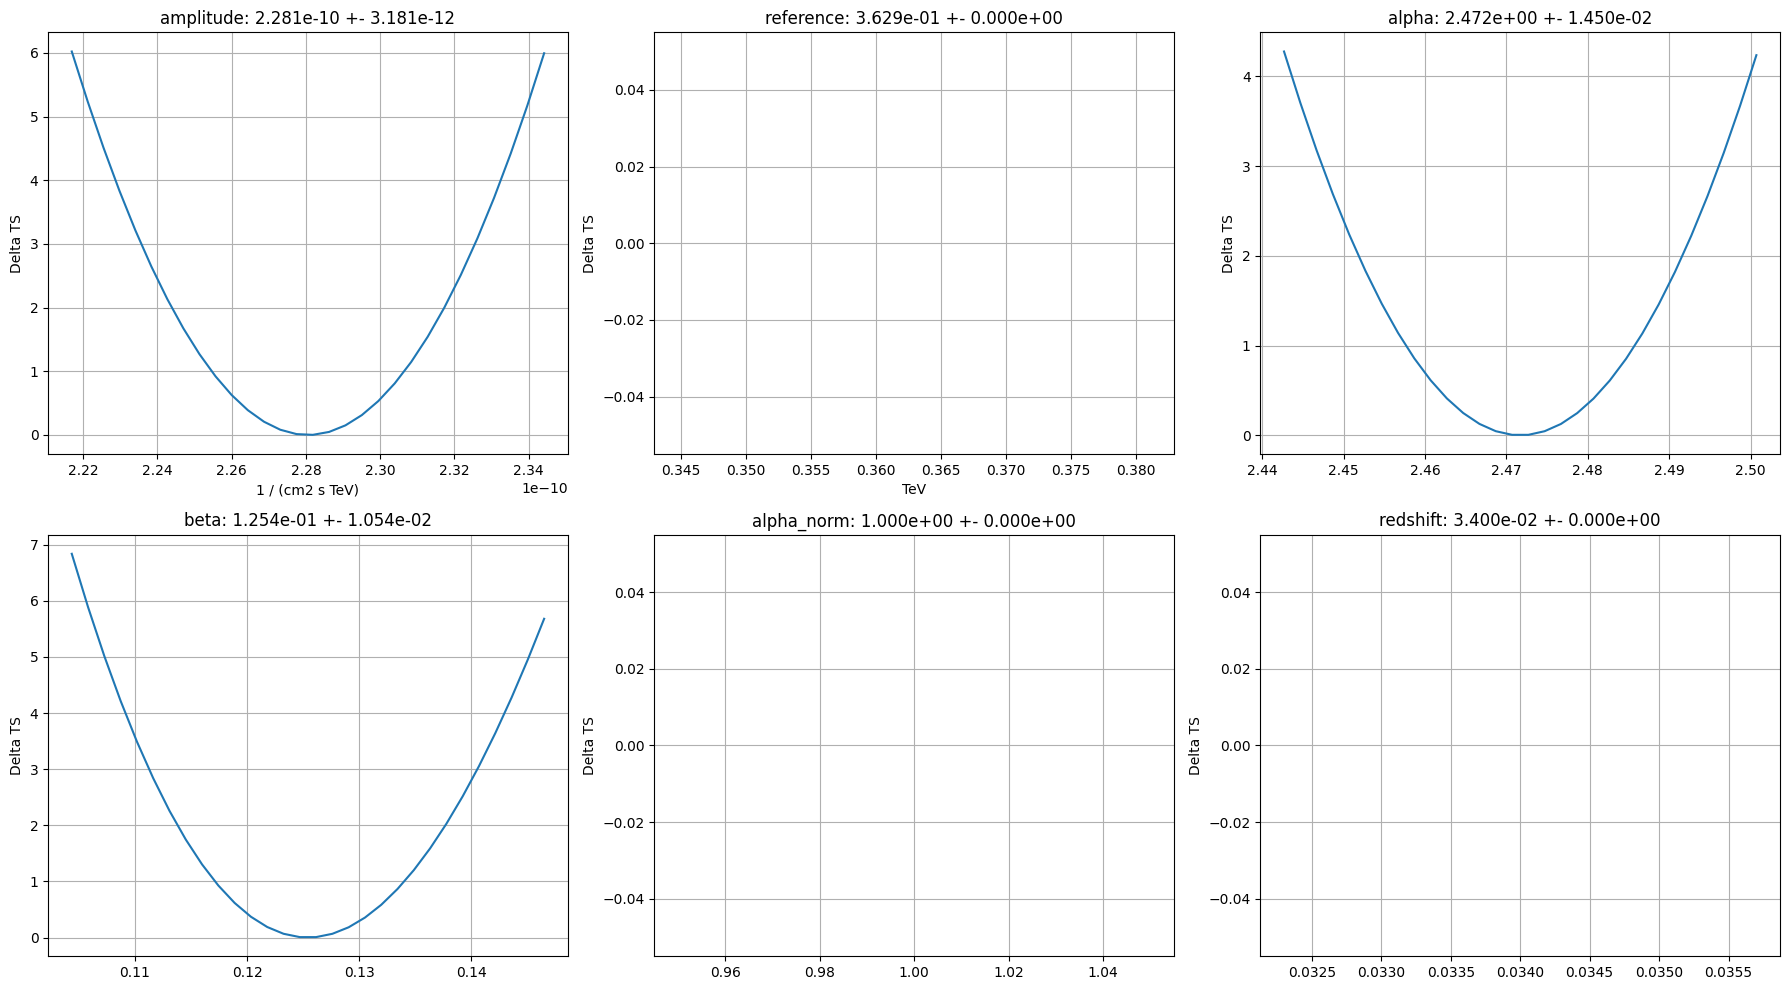

In [70]:
plt.figure(figsize=(ncol*6, nrow*5))
total_stat = result.total_stat
for i, par in enumerate(stacked_dataset.models.parameters):
    par.scan_n_values = 30

    profile = fit.stat_profile(datasets=[stacked_dataset], parameter=par)
    
    plt.subplot(nrow, ncol, i+1)
    plt.plot(profile[f"Mrk421.spectral.{par.name}_scan"], profile["stat_scan"] - total_stat)
    plt.xlabel(f"{par.unit}")
    plt.ylabel("Delta TS")
    plt.grid()
    plt.title(f"{par.name}: {par.value:.3e} +- {par.error:.3e}")
plt.tight_layout()

<Axes: >

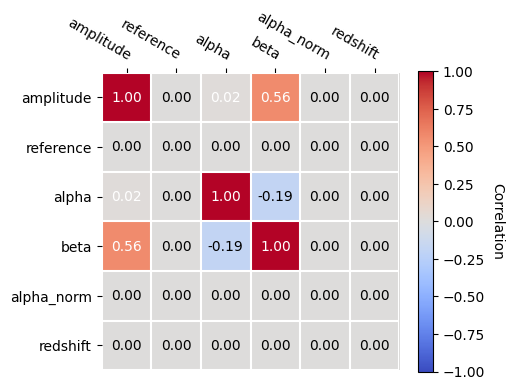

In [71]:
# Fit model covariance matrix plot
model_best.covariance.plot_correlation()

# SED

In [77]:
if obj_name == 'Crab':
    ref_label="MAGIC LP (JHEAp 2015)"
else:
    ref_label="Crab MAGIC LP (JHEAp 2015)"

In [78]:
e_plot_min = 0.01 * u.TeV
e_plot_max = 40 * u.TeV

use_ebl = True
if isinstance(model_best.spectral_model, CompoundSpectralModel):
    use_ebl = isinstance(model_best.spectral_model.model2, EBLAbsorptionNormSpectralModel)
ds_kwargs = {
    "sed_type": "dnde",
    "energy_bounds": [e_plot_min, e_plot_max]
}
sed_kwargs = {
    "sed_type": "e2dnde",
    "energy_bounds": [e_plot_min, e_plot_max]
}
lc_kwargs = {
    "sed_type": "flux",
    "axis_name": "time",
    "marker": "o", 
    "label": f"LST-1 data"
}
lc_night_kwargs = {
    "sed_type": "flux",
    "axis_name": "time",
    "marker": "o", 
    "label": f"LST-1 data night integrated"
}
if use_ebl:
    sed_plot_kwargs = {
        "sed_type": "e2dnde",
        "label": f"LST-1 data",
    }
    sed_plot_ebl_deabs_kwargs = {
        "sed_type": "e2dnde",
        "label": f"LST-1 data intrinsic",
    }
    sed_model_plot_kwargs = sed_kwargs.copy()
    sed_model_plot_kwargs["label"] = f"Best Fit model with EBL"
    sed_model_plot_ebl_deabs_kwargs = sed_kwargs.copy()
    sed_model_plot_ebl_deabs_kwargs["label"] = f"Best Fit intrinsic model"
else:
    sed_plot_kwargs = {
        "sed_type": "e2dnde",
        "label": f"LST-1 data",
    }
    sed_model_plot_kwargs = sed_kwargs.copy()
    sed_model_plot_kwargs["label"] = f"Best Fit model"

plot_ts_kwargs = {
    "sed_type": "e2dnde",
    "color": "darkorange"
}


In [79]:
# Calculate & plot Crab reference flux
# https://doi.org/10.1016/j.jheap.2015.01.002
crab = create_crab_spectral_model("magic_lp")
crab.amplitude.error = 0.03e-11 * u.Unit("cm-2 s-1 TeV-1")
crab.alpha.error = 0.01
crab.beta.error = 0.01/np.log(10)

flux_crab, flux_crab_error = crab.integral_error(e_lc_min, e_lc_max)
print(flux_crab, flux_crab_error)

4.761553903942733e-10 1 / (cm2 s) 1.0323417410630098e-11 1 / (cm2 s)


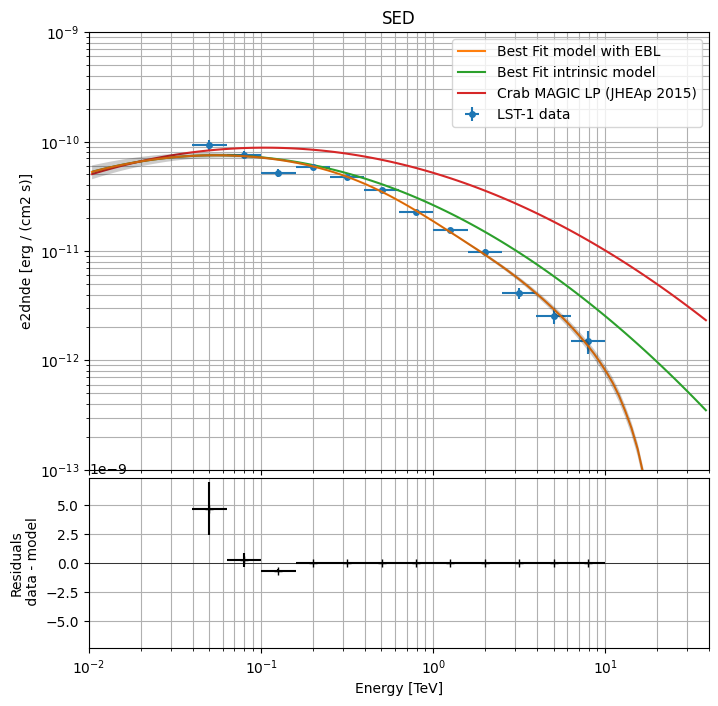

In [80]:
fig_sed = plt.figure(figsize=(8,8))

gs2 = GridSpec(7, 1)

gs2.update(hspace=0.1)
args1 = [gs2[:5,:]]
args2 = [gs2[5:,:]]

fig_gs1 = fig_sed.add_subplot(*args1)
fig_gs2 = fig_sed.add_subplot(*args2)

flux_points_dataset.plot_spectrum(
    ax=fig_gs1,
    kwargs_fp=sed_plot_kwargs, 
    kwargs_model=sed_model_plot_kwargs
)

if use_ebl:
    models2.spectral_model.plot(
        ax=fig_gs1,
        **sed_model_plot_ebl_deabs_kwargs
    )

create_crab_spectral_model("magic_lp").plot(
    ax=fig_gs1, **sed_kwargs, label=ref_label
)

fig_gs1.legend(bbox_to_anchor=(1,1))
fig_gs1.set_xlim(e_plot_min.value, e_plot_max.value)
fig_gs1.set_ylim(1e-13, 1e-9)
#fig_gs1.set_xlim(0.01, 2)
fig_gs2.set_xlim(e_plot_min.value, e_plot_max.value)
fig_gs1.tick_params(labelbottom=False)

fig_gs1.grid(which='both')
fig_gs1.set_title('SED')

flux_points_dataset.plot_residuals(ax=fig_gs2, method='diff')
fig_gs2.grid(which='both')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_26142/1077173865.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig_gs2.set_yticklabels(y_ticks_new)


[ 7.54294948e-01  7.13549266e-01  7.18619147e-01  2.96978342e-01
  2.45413172e-01  2.68997354e-01 -4.32019223e-10  1.27902055e+00
  9.97753894e-01  7.29621853e-01  1.04655461e+00  9.34869555e-01
  9.99368112e-01  8.34302933e-01  9.74435169e-01  4.73167886e-01
  4.02831534e-01  6.48744930e-01  1.00935608e+00  3.92366456e-01
  4.28106695e-01  3.24466014e-01  6.18240355e-01  3.29254149e-01
  1.29448170e-01 -1.11656572e-08  4.89165044e-01  1.20902620e+00
  6.55325730e-01  5.72453145e-01  6.82511608e-01  1.08650086e+00
  1.92642926e-01  3.54232114e-01  7.50515365e-01  3.26756227e-01
  6.98494433e-02  5.97618889e-01  2.94931023e+00  1.40598828e+00
  1.75204780e+00  1.26876343e+00]
[0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8]


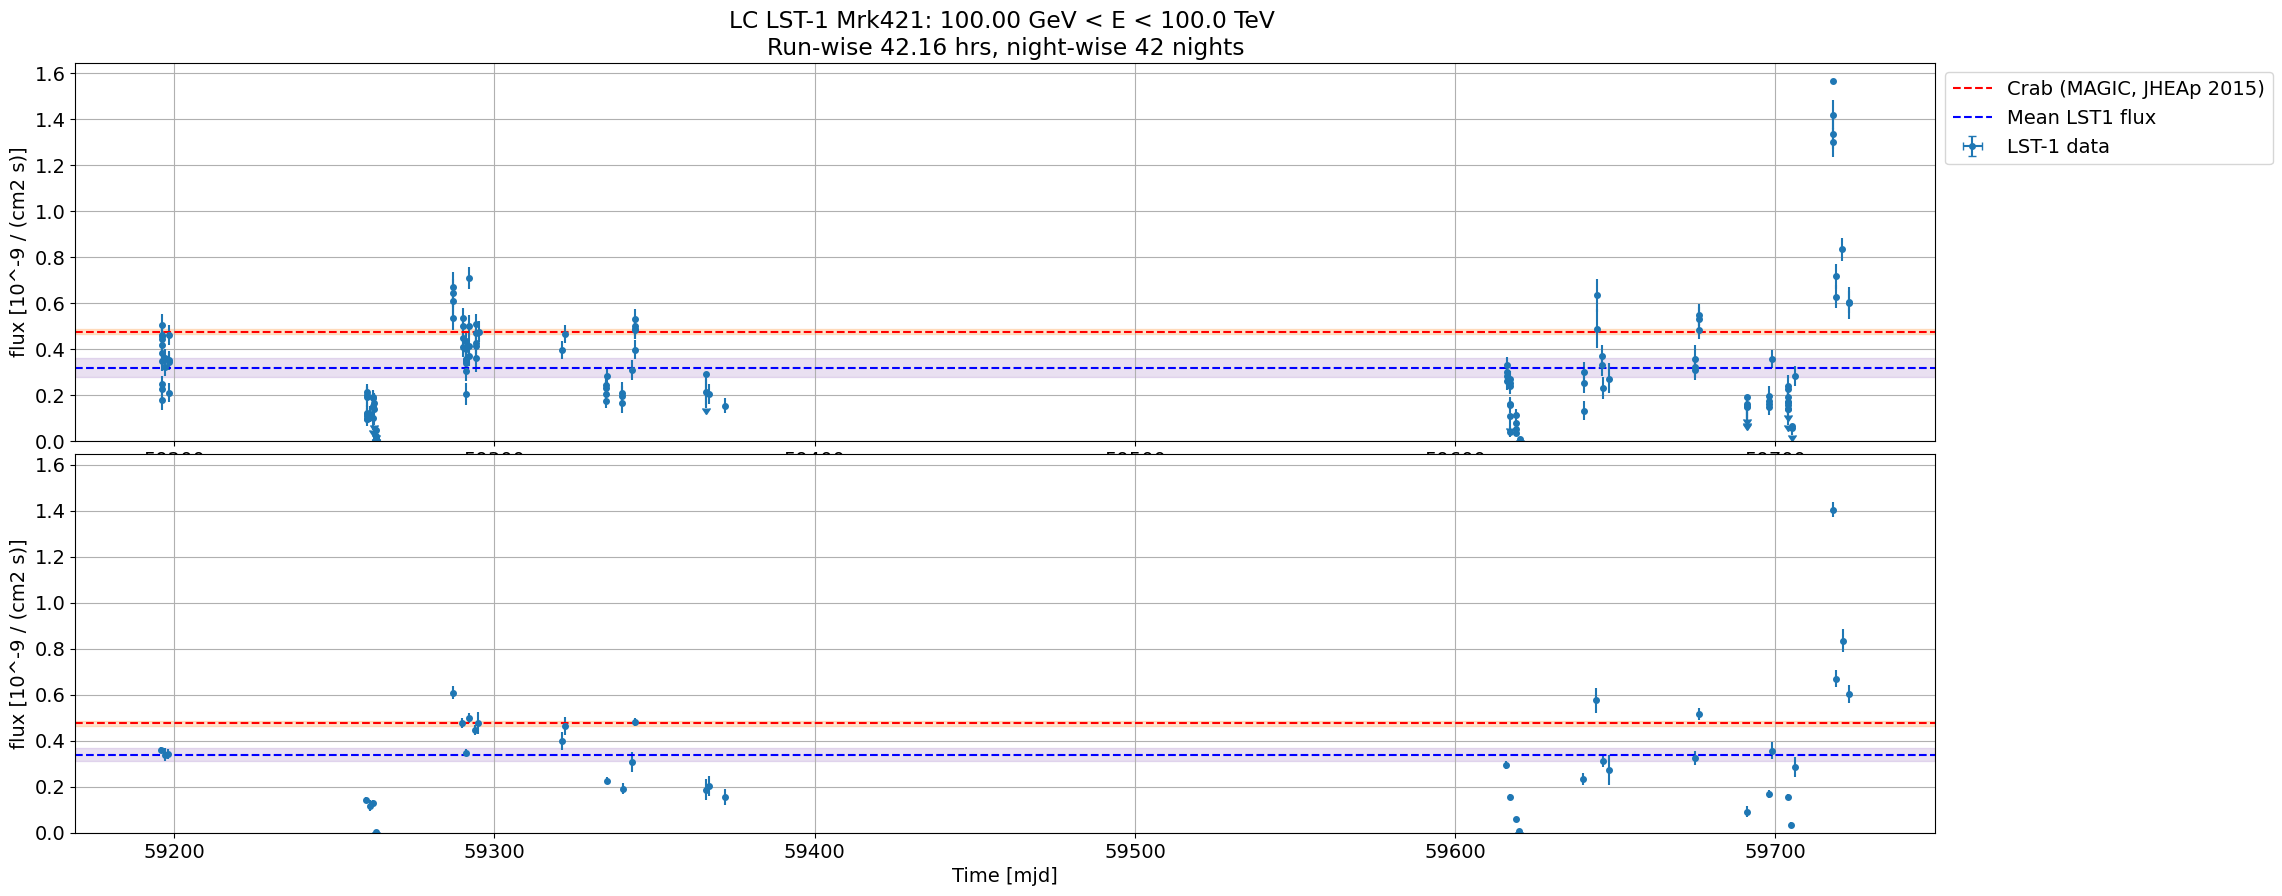

In [81]:
# Primary LC curves with 'Full Energy range', run-wise and night-wise
if len(t_day) > 1:
    fig_lc = plt.figure(figsize=(24,10))

    gs2 = GridSpec(10, 5) #, hspace=0
    plt.rcParams['font.size'] = '14'
    args1 = [gs2[:5,:]]
    args2 = [gs2[5:,:]]

    fig_gs1 = fig_lc.add_subplot(*args1)
    fig_gs2 = fig_lc.add_subplot(*args2, sharey=fig_gs1, sharex=fig_gs1)

    lc_1d.plot(
        ax=fig_gs1,
        **lc_kwargs
    )
    fig_gs1.axhline(
        flux_crab.to_value("cm-2 s-1"), c='red', ls='--', 
        label='Crab (MAGIC, JHEAp 2015)'
    )
    fig_gs1.axhline(
        np.nanmean(lc_1d.flux.data), c="blue", ls='--',
        label="Mean LST1 flux"
    )
    fig_gs1.axhspan(
        (flux_crab - flux_crab_error).to_value("cm-2 s-1"), 
        (flux_crab + flux_crab_error).to_value("cm-2 s-1"), 
        alpha=0.2, color='tab:orange'
    )
    fig_gs1.axhspan(
        (np.nanmean(lc_1d.flux.data) - np.nanmean(lc_1d.flux_errn.data)),
        (np.nanmean(lc_1d.flux.data) + np.nanmean(lc_1d.flux_errp.data)),
        alpha=0.2, color="tab:purple"
    )
    fig_gs1.grid(which='both')
    fig_gs1.set_yscale("linear")
    fig_gs1.set_ylim(bottom=0)
    fig_gs1.set_title(
        f'LC LST-1 {obj_name}: {e_lc_min.to(u.GeV):.2f} < E < {e_lc_max:.1f} ' + 
        f'\nRun-wise {tot_time.sum()/3600:.2f} hrs, night-wise {len(t_day)} nights'
    )
    fig_gs1.legend(bbox_to_anchor=(1.,1))

    lc_night.plot(
        ax=fig_gs2,
        **lc_kwargs
    )
    fig_gs2.axhline(
        flux_crab.to_value("cm-2 s-1"), c='red', ls='--', 
        label='Crab (MAGIC, JHEAp 2015)'
    )
    fig_gs2.axhline(
        np.nanmean(lc_night.flux.data), c="blue", ls='--',
        label="Mean LST1 flux"
    )

    fig_gs2.axhspan(
        (flux_crab - flux_crab_error).to_value("cm-2 s-1"), 
        (flux_crab + flux_crab_error).to_value("cm-2 s-1"), 
        alpha=0.2, color='tab:orange'
    )
    fig_gs2.axhspan(
        (np.nanmean(lc_night.flux.data) - np.nanmean(lc_night.flux_errn.data)),
        (np.nanmean(lc_night.flux.data) + np.nanmean(lc_night.flux_errp.data)),
        alpha=0.2, color="tab:purple"
    )

    flux_in_cu = lc_night["flux"].quantity.ravel()/flux_crab

    print(flux_in_cu)

    fig_gs2.set_yscale("linear")
    fig_gs2.set_ylim(bottom=0)
    fig_gs2.grid(which='both')

    yticks = fig_gs2.get_yticks()

    y_max = fig_gs2.get_ylim()[1]
    y_exp = int(np.floor(np.log10(y_max)))
    #y_max_new = y_max * 10**(-y_exp)

    y_ticks_new = np.around(yticks*10**(-y_exp), decimals=2)
    print(y_ticks_new)
    fig_gs2.set_yticklabels(y_ticks_new)
    y_label_new = fig_gs2.get_ylabel().replace("1", f"10^{y_exp}")
    fig_gs2.set_ylabel(y_label_new)
    fig_gs1.set_ylabel(y_label_new)

    fig_gs2.legend().remove()

else:
    fig, ax = plt.subplots(figsize=(8,5))
    plt.rcParams['font.size'] = '10'
    lc_1d.plot(
        ax=ax,
        **lc_kwargs
    )
    plt.axhline(
        flux_crab.to_value("cm-2 s-1"), c='red', ls='--', 
        label='Crab (MAGIC, JHEAp 2015)'
    )
    plt.axhline(
        np.nanmean(lc_1d.flux.data), c="blue", ls='--',
        label="Mean LST1 flux"
    )
    plt.axhspan(
        (flux_crab - flux_crab_error).to_value("cm-2 s-1"), 
        (flux_crab + flux_crab_error).to_value("cm-2 s-1"), 
        alpha=0.2, color='tab:orange'
    )
    plt.axhspan(
        (np.nanmean(lc_1d.flux.data) - np.nanmean(lc_1d.flux_errn.data)),
        (np.nanmean(lc_1d.flux.data) + np.nanmean(lc_1d.flux_errp.data)),
        alpha=0.2, color="tab:purple"
    )
    plt.grid(which='both')
    plt.yscale("linear")
    plt.ylim(bottom=0)
    plt.title(
        f'LC LST-1 {obj_name}: {e_lc_min.to(u.GeV):.2f} < E < {e_lc_max:.1f} ' + 
        f'\nRun-wise {tot_time.sum()/3600:.2f} hrs'
    )
    yticks = ax.get_yticks()

    y_max = ax.get_ylim()[1]
    y_exp = int(np.floor(np.log10(y_max)))
    #y_max_new = y_max * 10**(-y_exp)

    y_ticks_new = np.around(yticks*10**(-y_exp), decimals=2)
    print(y_ticks_new)
    ax.set_yticklabels(y_ticks_new)
    y_label_new = ax.get_ylabel().replace("1", f"10^{y_exp}")
    ax.set_ylabel(y_label_new)
    
    plt.legend(bbox_to_anchor=(1.,1))